### ==============================================================================
### 🚀 Profiling High-Risk vs. Low-Risk Production Runs
### ==============================================================================

We can use our model to analyze all the real production runs in our test set and answer the question:

`"For the runs that are predicted to have a high defect rate, what do their production parameters look like compared to the runs that are predicted to be successful?"`

In [26]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
print("1. Loading the saved model preprocessor, and original test data...")

# Load the pre-trained model and the preprocessor
loaded_model = joblib.load("../model/defect_rate_predictor.joblib")
loaded_preprocessor = joblib.load("../model/preprocessor.joblib")

print("✅ Model and preprocessor loaded successfully.")

1. Loading the saved model preprocessor, and original test data...
✅ Model and preprocessor loaded successfully.


In [29]:
# Load the raw dataset to get the original, untransformed test data
df_raw = pd.read_csv("../data/smart_phone_surface_plastic_manufacture.csv")
X = df_raw.drop(columns=["Defect Rate (%)", "Production Output (Units)", "Unnamed: 0", "Production Run ID", "Date"])
y = df_raw["Defect Rate (%)"].dropna()

In [30]:
# Split the data into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X.loc[y.index], y, test_size=0.2, random_state=42)

In [31]:
# Engineer features on the raw test data
X_test_raw["Energy_per_Unit"] = X_test_raw["Energy Consumption (kWh)"] / (X_test_raw["Batch Size (Units)"] + 1e-6)
X_test_raw["Process_Stress_Index"] = X_test_raw["Temperature (°C)"] * X_test_raw["Pressure (Pa)"]

In [32]:
# Preprocess the entire test set
X_test_processed = loaded_preprocessor.transform(X_test_raw)

In [33]:
# Get column names and create DataFrame
ohe_feature_names = loaded_preprocessor.named_transformers_["cat"].get_feature_names_out()
all_feature_names = (
    list(loaded_preprocessor.named_transformers_["skewed"].feature_names_in_) +
    list(loaded_preprocessor.named_transformers_["symmetric"].feature_names_in_) +
    list(ohe_feature_names)
)

X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

In [34]:
# Drop high-VIF columns
cols_to_drop = ["Process_Stress_Index", "Pressure (Pa)"]
X_test_final = X_test_processed_df.drop(columns=cols_to_drop)

In [35]:
# Make predictions on the entire test set
all_predictions = loaded_model.predict(X_test_final)

In [36]:
# Add predictions back to the original, untransformed test data for analysis
X_test_raw["Predicted_Defect_Rate"] = all_predictions

In [37]:
# --- 2. Create the Profiles ---
# Define a threshold for a "high defect rate" (e.g., top 25% of predictions)
high_defect_threshold = X_test_raw["Predicted_Defect_Rate"].quantile(0.75)

high_risk_runs = X_test_raw[X_test_raw["Predicted_Defect_Rate"] >= high_defect_threshold]
low_risk_runs = X_test_raw[X_test_raw["Predicted_Defect_Rate"] < high_defect_threshold]

In [38]:
# Calculate the average parameter values for each group
high_risk_profile = high_risk_runs.mean(numeric_only=True)
low_risk_profile = low_risk_runs.mean(numeric_only=True)

In [39]:
# Create a comparison DataFrame
profile_comparison = pd.DataFrame({
    "High-Risk Run (Average)": high_risk_profile,
    "Low-Risk Run (Average)": low_risk_profile
})

In [40]:
# Add a column for the difference to highlight key factors
profile_comparison["Difference"] = profile_comparison["High-Risk Run (Average)"] - profile_comparison["Low-Risk Run (Average)"]

In [41]:
# We only care about the most important features we identified
key_features = [
    "Downtime (Minutes)",
    "Raw Material Quality (Score)",
    "Cooling Rate (°C/min)",
    "Maintenance (Days Since)",
    "Temperature (°C)",
    "Machine Speed (RPM)"
]

In [42]:
print("\n--- Profile Comparison: High-Risk vs. Low-Risk Production Runs ---")
print(profile_comparison.loc[key_features])
print("-" * 50)


--- Profile Comparison: High-Risk vs. Low-Risk Production Runs ---
                              High-Risk Run (Average)  Low-Risk Run (Average)  \
Downtime (Minutes)                          45.253968               29.431127   
Raw Material Quality (Score)                81.462016               85.411470   
Cooling Rate (°C/min)                        4.730833                5.032534   
Maintenance (Days Since)                    34.478947               29.854352   
Temperature (°C)                           210.902659              201.109362   
Machine Speed (RPM)                       1524.714360             1503.485662   

                              Difference  
Downtime (Minutes)             15.822841  
Raw Material Quality (Score)   -3.949454  
Cooling Rate (°C/min)          -0.301701  
Maintenance (Days Since)        4.624596  
Temperature (°C)                9.793297  
Machine Speed (RPM)            21.228699  
--------------------------------------------------


### Observation

The comparison between high-risk and low-risk production runs reveals a clear and actionable pattern. The model has learned that a run is likely to have a high defect rate when a specific combination of conditions occurs.

Compared to successful (low-risk) runs, the high-risk runs have, on average:

* **Significantly More Downtime:** Downtime is over 15 minutes longer on average, confirming it as a major contributor to quality issues.
* **Noticeably Lower Raw Material Quality:** The quality score is almost 4 points lower, indicating that substandard materials are a key factor.
* **Higher Operating Temperatures:** The extrusion temperature is nearly 10°C hotter, suggesting that running the process too hot leads to defects.
* **Longer Delays in Maintenance:** Maintenance is overdue by an additional 4.6 days, implying that poorly maintained machines are less reliable.
* **Slightly Higher Machine Speeds and Lower Cooling Rates:** While smaller, these differences indicate that running the machines faster and cooling them slightly slower also contributes to the risk profile.

The model's key insight is that defects are not caused by one single factor, but by a combination of operational stresses. The most dangerous scenario is a run that has experienced significant downtime, is using lower-quality materials, and is running hotter than average on a machine that is due for maintenance.

In [43]:
# Visualization
# --- Prepare the data for plotting ---
# Select only the key features for the visualization
plot_data = profile_comparison.loc[key_features].copy()
# Reset the index so 'Feature' becomes a column
plot_data.reset_index(inplace=True)
# Rename the index column to 'Feature'
plot_data.rename(columns={"index": "Feature"}, inplace=True)

In [44]:
# Melt the DataFrame to prepare it for side-by-side plotting with seaborn
df_melted = plot_data.melt(
    id_vars="Feature",
    value_vars=["High-Risk Run (Average)", "Low-Risk Run (Average)"],
    var_name="Run Type",
    value_name="Average Value"
)

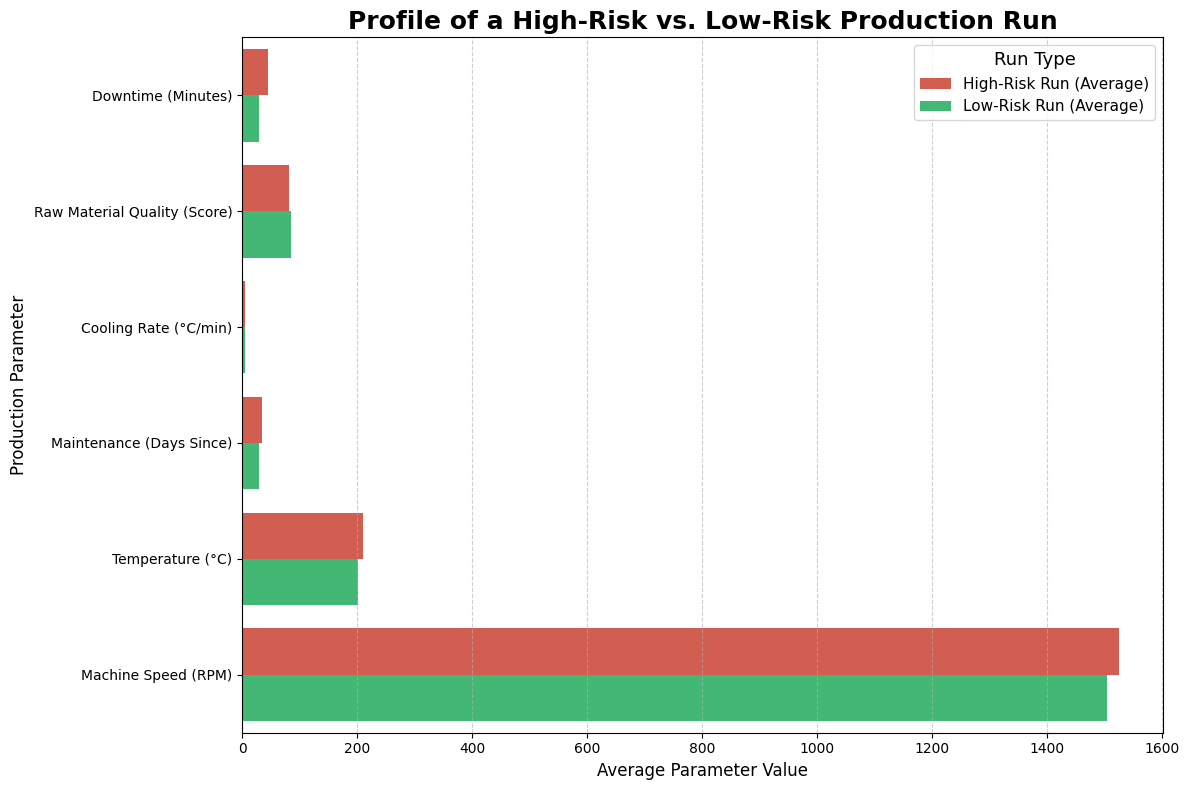

✅ Final business impact visualization created dynamically from the analysis.


In [45]:
# --- Create the Visualization ---
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df_melted,
    x="Average Value",
    y="Feature",
    hue="Run Type",
    palette={"High-Risk Run (Average)": "#e74c3c", "Low-Risk Run (Average)": "#2ecc71"}
)

plt.title("Profile of a High-Risk vs. Low-Risk Production Run", fontsize=18, fontweight='bold')
plt.xlabel("Average Parameter Value", fontsize=12)
plt.ylabel("Production Parameter", fontsize=12)
plt.legend(title="Run Type", title_fontsize="13", fontsize="11")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("../images/high_risk_profile_comparison.png")
plt.show()
plt.close()

print("✅ Final business impact visualization created dynamically from the analysis.")